In [1]:
import torch
import sklearn
import numpy as np
from mlp import MLP,reference
from tool import to_skl_tree
from sklearn.cluster import KMeans,DBSCAN
from rtree import DecisionTreeClassifier,RTreeClassifier

### extent and sample the original data

In [6]:
# original data
X = np.array([[0,0,0,0],
     [0,0,0,1],
     [0,0,1,0],
     [0,0,1,1],
     [0,1,0,0],
     [0,1,0,1],
     [0,1,1,0],
     [0,1,1,1],
     [1,0,0,0],
     [1,0,0,1],
     [1,0,1,0],
     [1,0,1,1],
     [1,1,0,0],
     [1,1,0,1],
     [1,1,1,0],
     [1,1,1,1]], dtype=np.float)
Y = np.array([0,1,1,1,1,1,1,1,0,1,1,1,0,1,0,0])
feature_names = ['x1','x2','x3','x4']

In [8]:
# extent the original data for 'training'
X1,X2,X3,X4 = np.linspace(0, 1, num=5),np.linspace(0, 1, num=5),np.linspace(0, 1, num=5),np.linspace(0, 1, num=5)
X_train = np.zeros([625, 4])
indice = []
for i in range(len(X1)):
    for j in range(len(X2)):
        for k in range(len(X3)):
            for l in range(len(X4)):
                index = i*(5**3)+j*(5**2)+k*5+l
                X_train[index][0] = X1[i]
                X_train[index][1] = X2[j]
                X_train[index][2] = X3[k]
                X_train[index][3] = X4[l]
                if (X1[i]==0 or X1[i]==1) and (X2[j]==0 or X2[j]==1) and \
                    (X3[k]==0 or X3[k]==1) and (X4[l]==0 or X4[l]==1):
                        indice.append(index)
print(X_train.shape)
print(indice)

(625, 4)
[0, 4, 20, 24, 100, 104, 120, 124, 500, 504, 520, 524, 600, 604, 620, 624]


### import the nlp model

In [7]:
mlp_classifier = torch.load(open('./find01_mlp.model', 'rb'))
mlp_classifier

MLP(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=64, out_features=2, bias=True)
    (7): Tanh()
  )
)

In [102]:
# output the prediction and hidden state
with torch.no_grad():
    hidden1 = mlp_classifier.layers[1](mlp_classifier.layers[0](torch.tensor(X_train, dtype=torch.float32))).numpy()
    hidden2 = mlp_classifier.layers[3](mlp_classifier.layers[2](torch.tensor(hidden1, dtype=torch.float32))).numpy()
    hidden3 = mlp_classifier.layers[5](mlp_classifier.layers[4](torch.tensor(hidden2, dtype=torch.float32))).numpy()
    hidden4 = mlp_classifier.layers[7](mlp_classifier.layers[6](torch.tensor(hidden3, dtype=torch.float32))).numpy()
    y_train,_ = reference(torch.tensor(X_train, dtype=torch.float32), mlp_classifier)
print(X_train.shape, hidden1.shape, hidden2.shape, hidden3.shape, hidden4.shape)


(625, 4) (625, 64) (625, 64) (625, 64) (625, 2)


/Users/dosonleung/Desktop/GZU/可解释人工智能/RTree/mlp.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)


### reduce the dimension of the hidden state

In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [11]:
def decompose(data, decomposer, d='sqrt', y=None):
    assert type(d) == int or type(d) == str
    if type(d) == str:
        assert d=='sqrt'
    if d == 'sqrt':
        d = int(np.sqrt(data.shape[-1])+0.5)
    if y is None:
        reducer = decomposer(n_components=d, random_state=0)
    else:
        reducer = decomposer(n_components=d, random_state=0)
    data_d = reducer.fit_transform(data)
    return data_d

In [13]:
hidden1_ = decompose(hidden1, PCA, d=16) #64->16
hidden2_ = decompose(hidden2, PCA, d=16) #64->16
hidden3_ = decompose(hidden3, PCA, d=16) #64->16
hidden1_.shape,hidden2_.shape,hidden3_.shape

((625, 16), (625, 16), (625, 16))

### to assure the hyperparameters by visualization

In [17]:
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from strategy import Strategy,build_strategy_topk
from visual import widen,denoise,arrow,vector_expand,nearest_point,flow

In [77]:
import imp
import visual
imp.reload(visual)
from visual import widen,denoise,arrow,vector_expand,nearest_point,flow

#### reduce the dimension for visulization

In [18]:
# reduce all the hidden state in dimension of 16 to 4
hidden_tsne_4d = TSNE(n_components=4, init='pca', method='exact', random_state=0)
hidden_tsne_h_4d = hidden_tsne_4d.fit_transform(np.concatenate((hidden1_, hidden2_, hidden3_)))

In [19]:
# reduce all the hidden state and original input in dimension of 4 to 2
hidden_tsne_2d = TSNE(n_components=2, init='pca', method='exact', random_state=0)
hidden_tsne_h_2d = hidden_tsne_2d.fit_transform(np.concatenate((X_train, hidden_tsne_h_4d)))

In [20]:
x_train_2d, hidden1_2d, hidden2_2d, hidden3_2d = \
    hidden_tsne_h_2d[:len(X_train)], \
    hidden_tsne_h_2d[len(X_train):len(X_train)*2], \
    hidden_tsne_h_2d[len(X_train)*2:len(X_train)*3],hidden_tsne_h_2d[len(X_train)*3:]

In [22]:
'''
Create a strategy function based on topk (currently only KMeans and DBSCAN are allowed)
input:
X: X= X0,X1,...,Xn The neural network to be imitated is distributed according to the output from high to low, and it can skip layers
cluster_parmas: parameters of the cluster
gamma: Determine the importance of the quantity (A & B) [1, +) The larger the more important, the default is 2
k1: According to the split score, take top k1 #internal branch from high to low
beta: The smaller the power [0-1] of the child's clustering contour score, the more important the contour coefficient is (must have, 0.5 is recommended)
k2: Take top according to the strategy performance from high to low #External branch
alpha: The smaller the power of the root clustering contour score [0-1], the more important the contour coefficient is (must have, 0.5 is recommended)
is_input_clustering: whether the first layer uses clustering, otherwise n_clusters=1
output:
Strategy two-dimensional array, the first dimension = n, the second dimension is equal to the number of strategies at all levels
Cluster One-dimensional array, each dimension is a cluster (including the input cluster, so it is longer than Strategy)
'''

"\nCreate a strategy function based on topk (currently only KMeans and DBSCAN are allowed)\nenter:\nX: X= X0,X1,...,Xn #The neural network to be imitated is distributed according to the output from high to low, and it can skip layers\ncluster_parmas: parameters of the cluster\ngamma: Determine the importance of the quantity (A & B) [1, +) The larger the more important, the default is 2\nk1: According to the split score, take top k1 #internal branch from high to low\nbeta: The smaller the power [0-1] of the child's clustering contour score, the more important the contour coefficient is (must have, 0.5 is recommended)\nk2: Take top according to the strategy performance from high to low #External branch\nalpha: The smaller the power of the root clustering contour score [0-1], the more important the contour coefficient is (must have, 0.5 is recommended)\nis_input_clustering: whether the first layer uses clustering, otherwise n_clusters=1\noutput:\nStrategy two-dimensional array, the first 

In [23]:
c,s = build_strategy_topk([x_train_2d, hidden1_2d, hidden2_2d, hidden3_2d], 
                     clustering=[KMeans, KMeans, DBSCAN], 
                     cluster_parmas=[{'n_clusters':5},{'n_clusters':4},{'n_clusters':5}],
                     k1=[5,2,2], k2=[3,5,4])

input  : KMeans(n_clusters=1)
trying 5 clustering in KMeans
layer 1 c: KMeans(n_clusters=5) g: 5 k1: 5 k2: 3 alpha: 0.5 beta: 0.5
trying 4 clustering in KMeans
layer 2 c: KMeans(n_clusters=4) g: 4 k1: 2 k2: 5 alpha: 0.5 beta: 0.5
trying 5 clustering in DBSCAN
dbscan_result: 5
layer 3 c: DBSCAN(eps=11.324764981575218) g: 5 k1: 2 k2: 4 alpha: 0.5 beta: 0.5


In [25]:
X_annotate = ['0000','0001','0010','0011','0100','0101','0110','0111',\
              '1000','1001','1010','1011','1100','1101','1110','1111']
annotate = []
for i in range(len(X_train)):
    if i in indice:
        annotate.append(X_annotate[indice.index(i)])
    else:
        annotate.append(None)
annotate = np.array(annotate)

#### visualization for the first layer

In [46]:
x_train_2dd,hidden1_2dd,keep_indice = denoise(x_train_2d, hidden1_2d, 0.01)
annotate_ = annotate[keep_indice]
x_train_label,hidden1_label = c[0].predict(x_train_2dd),c[1].predict(hidden1_2dd)
print(x_train_2d.shape, hidden1_2d.shape, x_train_2dd.shape, hidden1_2dd.shape, len(x_train_label), len(hidden1_label))


(625, 2) (625, 2) (619, 2) (619, 2) 619 619


In [47]:
x_train_2dd,hidden1_2dd = \
    vector_expand(x_train_2dd, x_train_label, c[0].cluster_centers_, k=1.5),\
    vector_expand(hidden1_2dd, hidden1_label, c[1].cluster_centers_, k=2.0)
bias1,bias2 = widen(x_train_2dd, hidden1_2dd, k=3.0)
x_train_2d_ = np.array(x_train_2dd)
hidden1_2d_  = np.array(hidden1_2dd)
x_train_2d_ += bias1 + np.array([30, 0], dtype=np.float32)
hidden1_2d_ += bias2
from_center_ = c[0].cluster_centers_ + bias1 + np.array([30, 0], dtype=np.float32)
to_center_ = c[1].cluster_centers_ + bias2

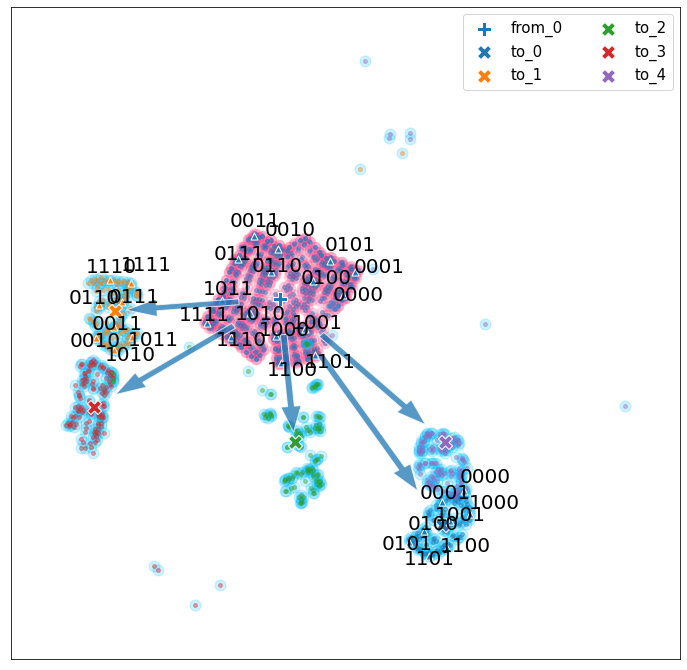

In [48]:
flow(x_train_2d_[:, 0], hidden1_2d_[:, 0],
     x_train_2d_[:, 1], hidden1_2d_[:, 1],
     from_label=x_train_label.tolist(), to_label=hidden1_label.tolist(),
     from_center=from_center_, to_center=to_center_,
     from_annotate=annotate_, to_annotate=annotate_,
     strategy=s[0], draw_arrow=False, arrow_size=0.04)

#### from the visualization, we can preliminarily assure the parameters of the 1st layer:
- k1 = 5
- k2 = 1
- n_clusters = 5
- clustering = KMeans/DBSCAN

#### visualization for the second layer

In [49]:
hidden1_2dd,hidden2_2dd,keep_indice = denoise(hidden1_2d, hidden2_2d, 0.01)
hidden1_label,hidden2_label = c[1].predict(hidden1_2dd),c[2].predict(hidden2_2dd)
annotate_ = annotate[keep_indice]
print(hidden1_2d.shape, hidden2_2d.shape, hidden1_2dd.shape, hidden2_2dd.shape)

(625, 2) (625, 2) (619, 2) (619, 2)


In [50]:
hidden1_2dd,hidden2_2dd = \
    vector_expand(hidden1_2dd, hidden1_label, c[1].cluster_centers_, k=2.0), \
    vector_expand(hidden2_2dd, hidden2_label, c[2].cluster_centers_, k=1.5)
bias1,bias2 = widen(hidden1_2dd, hidden2_2dd, k=12)
hidden1_2dd_ = np.array(hidden1_2dd)
hidden2_2dd_  = np.array(hidden2_2dd)
hidden1_2dd_ += bias1 + np.array([0, -10], dtype=np.float32)
hidden2_2dd_ += bias2 + np.array([0, 20], dtype=np.float32)
from_center_ = c[1].cluster_centers_ + bias1 + np.array([0, -10], dtype=np.float32)
to_center_ = c[2].cluster_centers_ + bias2 + np.array([0, 20], dtype=np.float32)

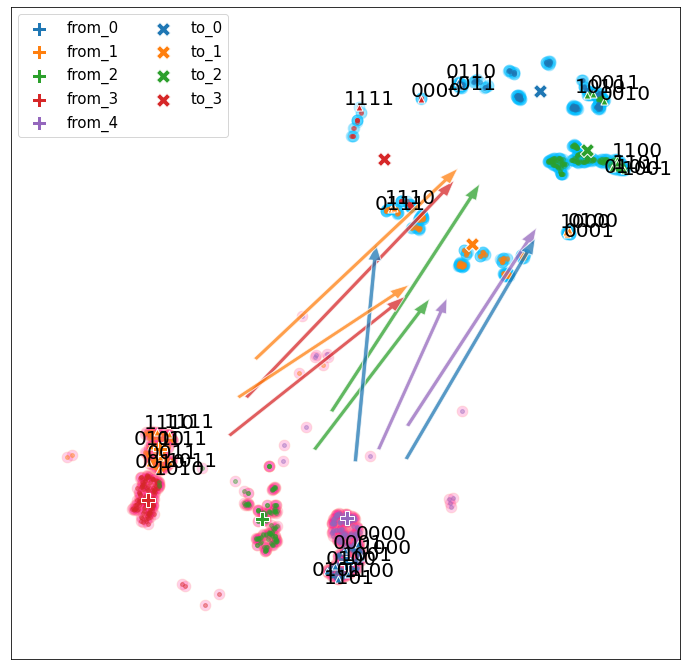

In [51]:
flow(hidden1_2dd_[:, 0], hidden2_2dd_[:, 0],
     hidden1_2dd_[:, 1], hidden2_2dd_[:, 1],
     from_label=hidden1_label.tolist(), to_label=hidden2_label.tolist(),
     from_center=from_center_, to_center=to_center_,
     from_annotate=annotate_, to_annotate=annotate_,
     strategy=s[1], draw_arrow=False, arrow_size=0.025)

#### from the visualization, we can preliminarily assure the parameters of the 2nd layer:
- k1 = 2
- k2 = 4
- n_clusters = 5
- clustering = KMeans

#### visualization for the third layer

In [61]:
hidden2_2dd,hidden3_2dd,keep_indice = denoise(hidden2_2d, hidden3_2d, 0.01)
hidden2_label,hidden3_label = c[2].predict(hidden2_2dd),c[3].predict(hidden3_2dd)
annotate_ = annotate[keep_indice]
print(hidden2_2d.shape, hidden3_2d.shape, hidden2_2dd.shape, hidden3_2dd.shape)

(625, 2) (625, 2) (619, 2) (619, 2)


In [62]:
hidden2_2dd,hidden3_2dd = \
    vector_expand(hidden2_2dd, hidden2_label, c[2].cluster_centers_, k=2.0), \
    vector_expand(hidden3_2dd, hidden3_label, c[3].cluster_centers_, k=1.5)
bias1,bias2 = widen(hidden2_2dd, hidden3_2dd, k=12)
hidden2_2dd_ = np.array(hidden2_2dd)
hidden3_2dd_  = np.array(hidden3_2dd)
hidden2_2dd_ += bias1 + np.array([0, -10], dtype=np.float32)
hidden3_2dd_ += bias2 + np.array([0, 20], dtype=np.float32)
from_center_ = c[2].cluster_centers_ + bias1 + np.array([0, -10], dtype=np.float32)
to_center_ = c[3].cluster_centers_ + bias2 + np.array([0, 20], dtype=np.float32)

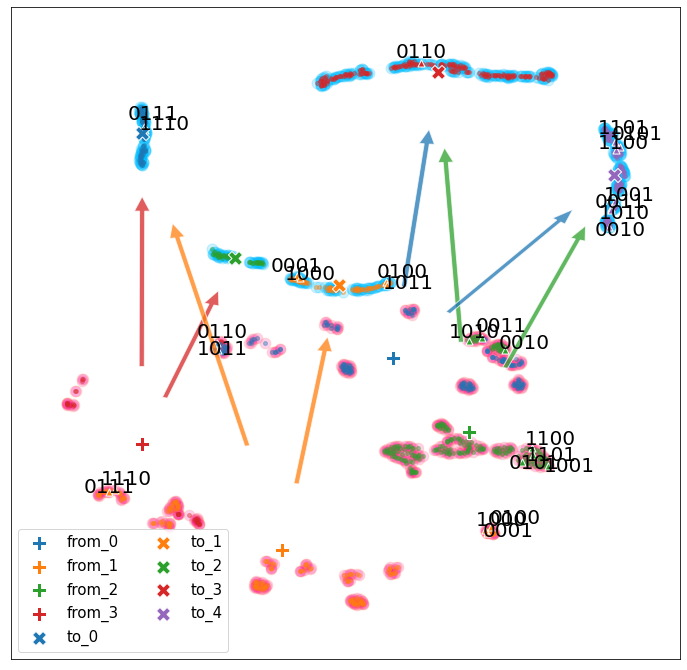

In [63]:
flow(hidden2_2dd_[:, 0], hidden3_2dd_[:, 0],
     hidden2_2dd_[:, 1], hidden3_2dd_[:, 1],
     from_label=hidden2_label.tolist(), to_label=hidden3_label.tolist(),
     from_center=from_center_, to_center=to_center_,
     from_annotate=annotate_, to_annotate=annotate_,
     strategy=s[2], draw_arrow=False, arrow_size=0.025)

#### from the visualization, we can preliminarily assure the parameters of the 3rd layer:
- k1 = 2
- k2 = 4
- n_clusters = 4
- clustering = KMeans/DBSCAN

### "Training?" imitate the host model //we didn't considerate the last layer for simple explanation

In [67]:
clusters,strategies = build_strategy_topk([X_train, hidden1_, hidden2_], 
                     clustering=[KMeans, KMeans], 
                     cluster_parmas=[{'n_clusters':5},{'n_clusters':5}],
                     k1=[5,2], k2=[1,4])

input  : KMeans(n_clusters=1)
trying 5 clustering in KMeans
layer 1 c: KMeans(n_clusters=5) g: 5 k1: 5 k2: 1 alpha: 0.5 beta: 0.5
trying 5 clustering in KMeans
layer 2 c: KMeans(n_clusters=5) g: 5 k1: 2 k2: 4 alpha: 0.5 beta: 0.5


In [70]:
# use original data and the corresponding hidden states
X_o,Y_o,h_o1,h_o2 = [],[],[],[]
for i in range(len(X_train)):
    if (X_train[i][0]==0 or X_train[i][0]==1) and (X_train[i][1]==0 or X_train[i][1]==1) and\
        (X_train[i][2]==0 or X_train[i][2]==1) and (X_train[i][3]==0 or X_train[i][3]==1):
        X_o.append(X_train[i])
        Y_o.append(y_train[i])
        h_o1.append(hidden1_[i])
        h_o2.append(hidden2_[i])
h_o1 = np.stack(h_o1)
h_o2 = np.stack(h_o2)

In [72]:
rtree_o = RTreeClassifier(
                criterion='gini', 
                max_depth=5, min_impurity_decrease=0.0, min_samples_split=1, 
                min_rest_depth=2, max_substree_depth=1, rashomon=0.75,
                feature_name=feature_names, 
                class_name=['F','T'],
                clusters=clusters, 
                strategies=strategies,
                logs=False)
rtree_o.fit([X_o, h_o1, h_o2], Y_o)

RTreeClassifier(class_name=['F', 'T'],
                clusters=[KMeans(n_clusters=1),
                criterion='gini', feature_name=['x1', 'x2', 'x3', 'x4'],
                logs=False, max_depth=5, max_substree_depth=1,
                min_impurity_decrease=[0.0, 0.0, 0.0],
                min_samples_split=[1, 1, 1], rashomon=0.75,
                strategies=[[<strategy.Strategy object at 0x7f9cb2054ee0>],
                             <strategy.Strategy object at 0x7f9cb2054130>]])

### Tree Visualization for explanation

In [74]:
from visual import print_tree

In [89]:
import imp
import visual
imp.reload(visual)
from visual import print_tree

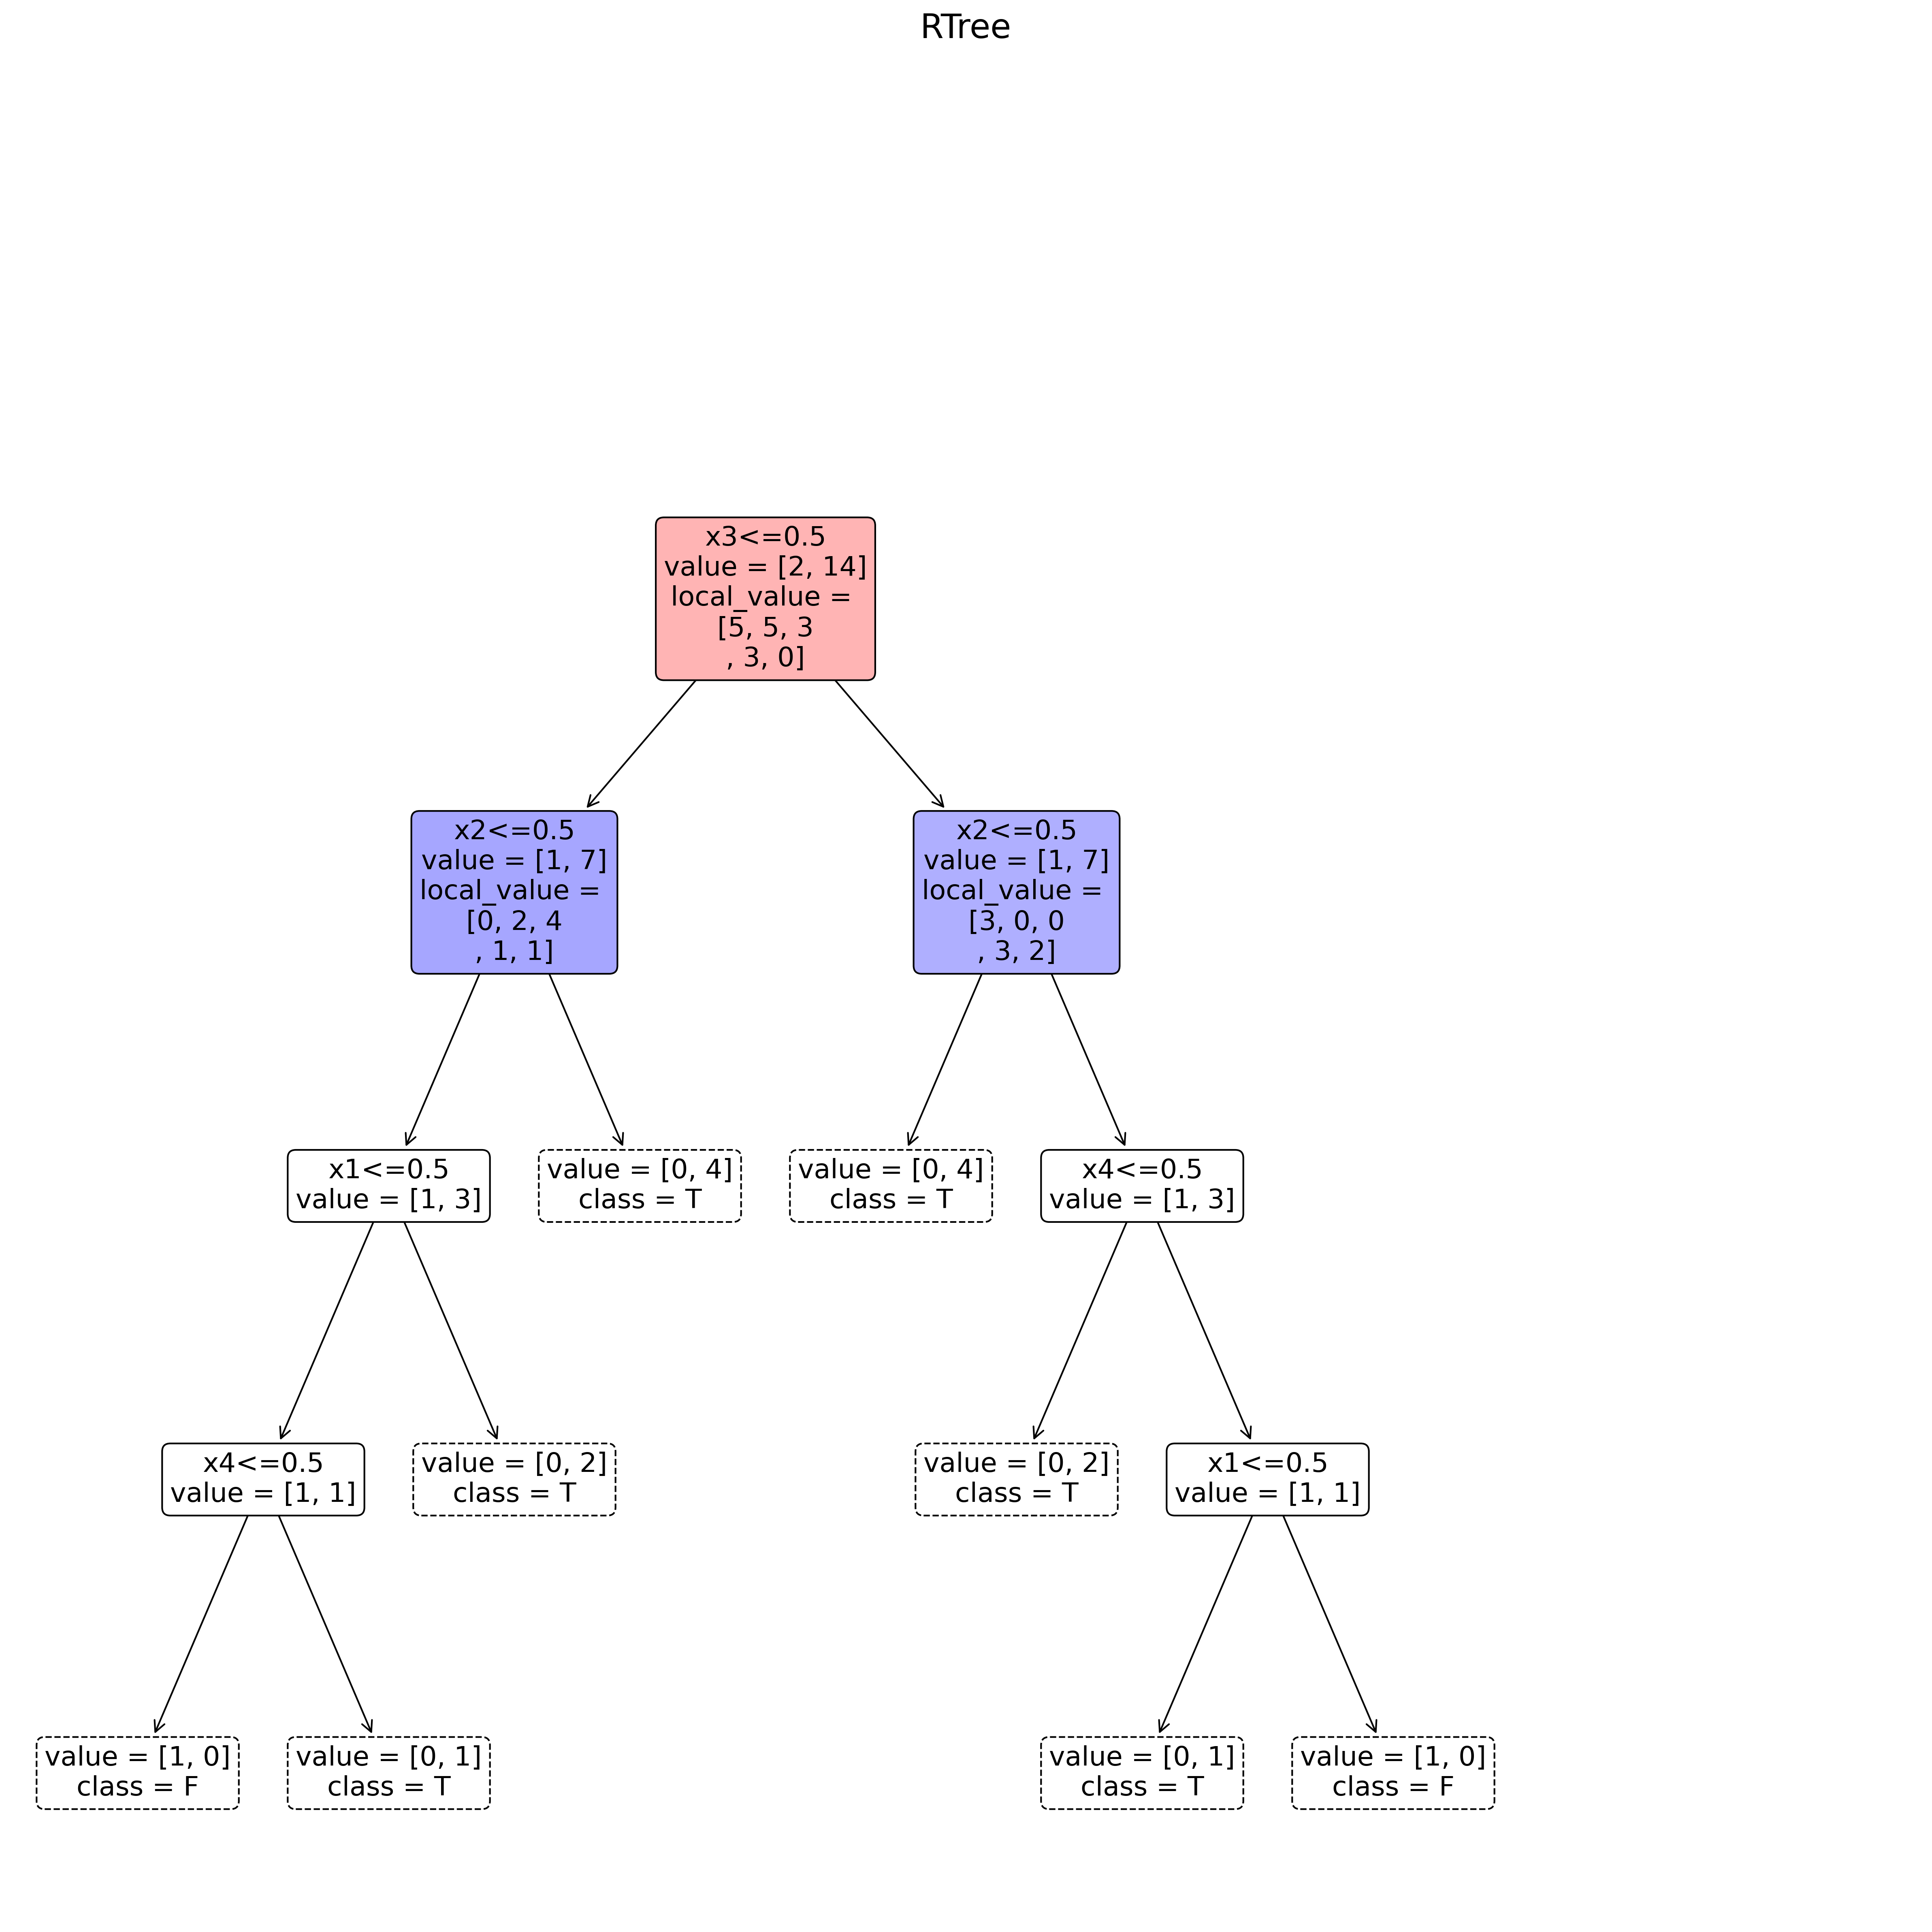

In [90]:
print_tree(rtree_o, feature_names=feature_names, title='RTree', class_names=['F','T'],\
           max_alpha=0.5, min_alpha=0.2, fontsize=16)

### Train the detailed tree with X_train,y_train and explain 

In [98]:
rtree = RTreeClassifier(
            criterion='gini', 
            max_depth=16, min_impurity_decrease=0.0, min_samples_split=2, 
            min_rest_depth=8, max_substree_depth=3, rashomon=0.5,
            strategy_type='topk', 
            strategy_param={
            'k1':[5,2,2], 'k2':[1,4,4], 
            'clustering':[KMeans, KMeans, KMeans], 
            'cluster_parmas':[{'n_clusters':5},{'n_clusters':5},{'n_clusters':4}]
            },
            feature_name=feature_names, 
            class_name=['F','T'],
            clusters=None, 
            strategies=None,
            logs=True)
rtree.fit([X_train, hidden1_, hidden2_, hidden3_], y_train)

input  : KMeans(n_clusters=1)
trying 5 clustering in KMeans
layer 1 c: KMeans(n_clusters=5) g: 5 k1: 5 k2: 1 alpha: 0.5 beta: 0.5
trying 5 clustering in KMeans
layer 2 c: KMeans(n_clusters=5) g: 5 k1: 2 k2: 4 alpha: 0.5 beta: 0.5
trying 4 clustering in KMeans
layer 3 c: KMeans(n_clusters=4) g: 4 k1: 2 k2: 4 alpha: 0.5 beta: 0.5
-------------------------------------------
current_strategy_layer: 0 slibling_num: 1
matching_index: 0 matching_s1: 1.0 matching_s2: 1.0 [1.0] [1.0]
matching strategy: {'G_root': 0, 'G_child': [3, 1, 0, 4, 2], 'S_root': 13.4117, 'S_child': [19.751, 18.9059, 12.689, 8.2089, 7.5035], 'S_conn': [36.0, 37.4544, 23.4256, 16.3216, 16.0]}
-------------------------------------------
current_strategy_layer: 1 slibling_num: 3
matching_index: 0 matching_s1: 0.68 matching_s2: 0.2048 [0.68, 0.0, 0.0, 0.0] [0.2048, 0.0, 0.0, 0.0]
matching strategy: {'G_root': 3, 'G_child': [0, 4], 'S_root': 14.7499, 'S_child': [24.0582, 21.1893], 'S_conn': [38.5067, 36.5067]}
---------------

RTreeClassifier(class_name=['F', 'T'],
                clusters=[KMeans(n_clusters=1),
                criterion='gini', feature_name=['x1', 'x2', 'x3', 'x4'],
                logs=True, max_depth=16, max_substree_depth=3,
                min_impurity_decrease=[0.0, 0.0, 0.0, 0.0], min_rest_depth=8,
                min_s...
         2.18891873e-04, -1.25122649e-04, -3.09603754e-04]], dtype=float32)],
                                'cluster_parmas': [{},
                                                   {'init': 'k-means++',
                                                    'n_clusters': 5},
                                                   {'init': 'k-means++',
                                                    'n_clusters': 5},
                                                   {'init': 'k-means++',
                                                    'n_clusters': 4}],
                                'clustering': [KMeans(n_clusters=1),
                                          

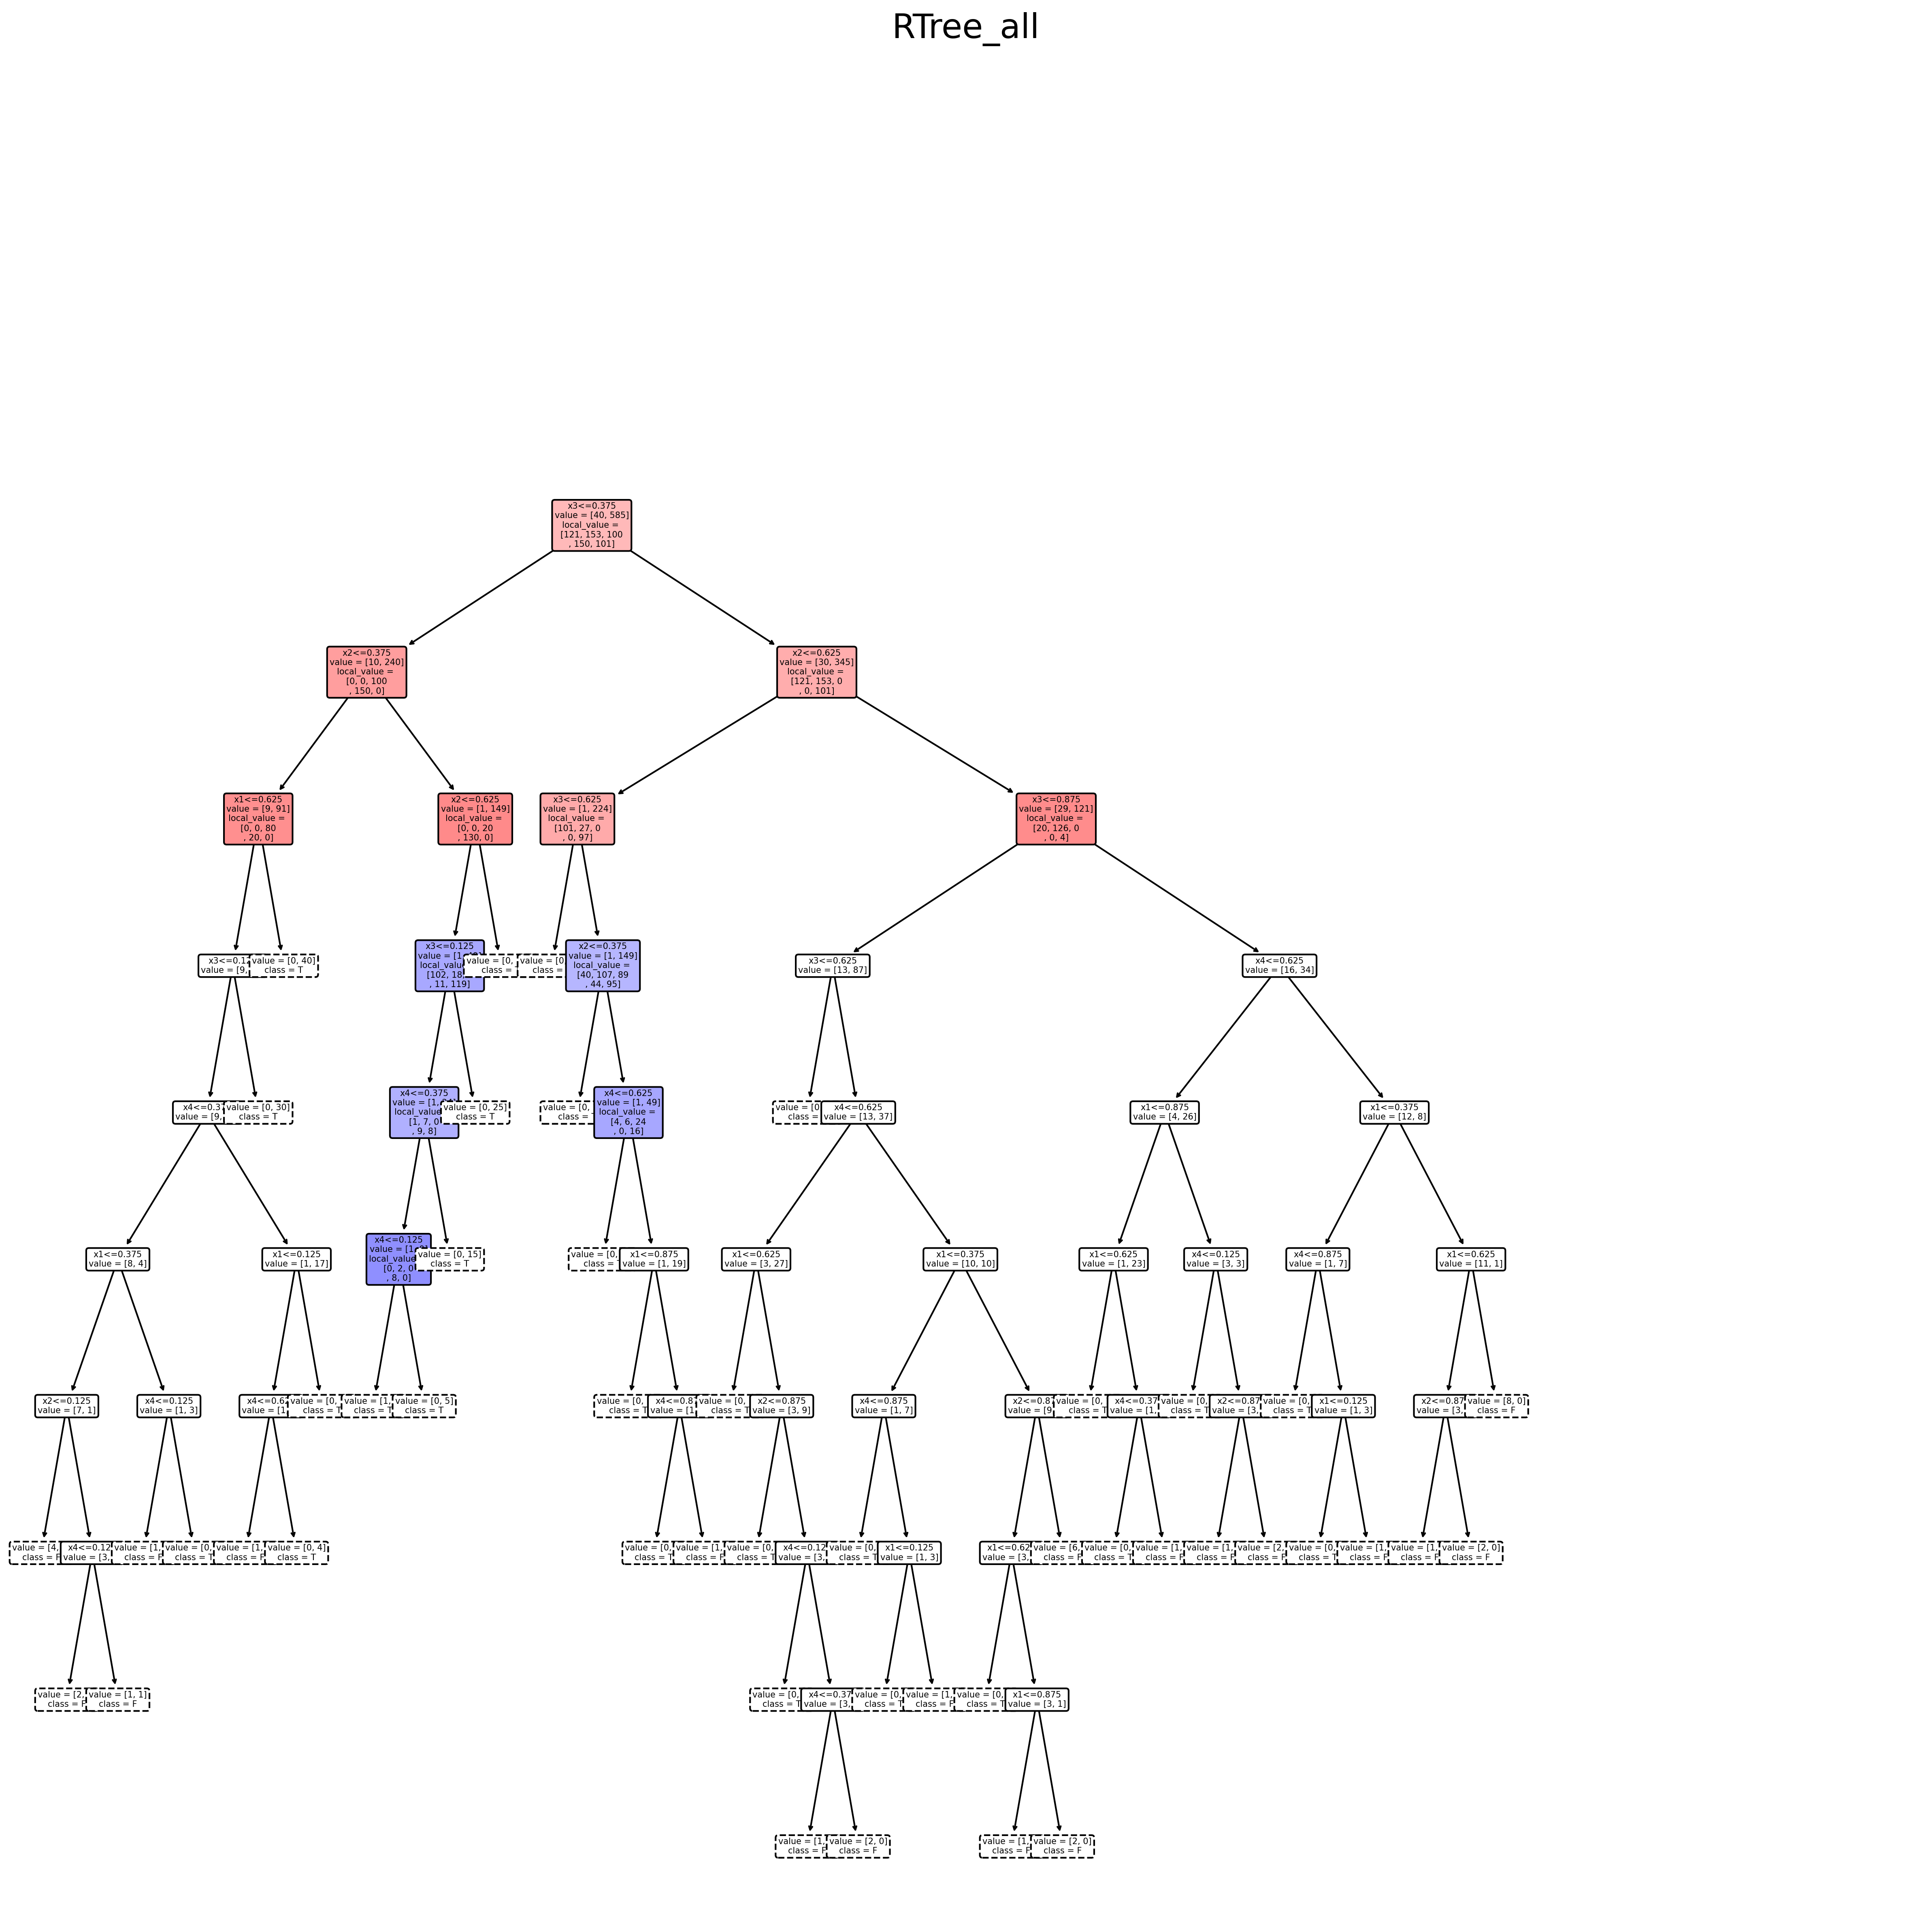

In [100]:
print_tree(rtree, feature_names=feature_names, title='RTree_all', class_names=['F','T'],\
           max_alpha=0.5, min_alpha=0.2, fontsize=5)